# Set Up

In [1]:
%load_ext autoreload
%autoreload 2
from importlib import reload

In [2]:
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import off_sample_utils as utils

/data/intsco/miniconda3/envs/off-smpl/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
Using TensorFlow backend.


In [4]:
from pathlib import Path

In [5]:
# utils.check_tf_dev()

In [6]:
IMAGE_SHAPE = (64, 64)
gs_path = Path('./GS/raw_images')

In [7]:
from skimage import transform
import imageio
import keras
import numpy as np
import pandas as pd
import sklearn
import matplotlib
keras.__version__, pd.__version__, np.__version__, matplotlib.__version__, sklearn.__version__

('2.2.4', '0.23.4', '1.12.1', '2.0.2', '0.20.0')

In [8]:
from sklearn.metrics import accuracy_score

# Load Data

In [9]:
import pickle
from skimage import transform
import imageio
import warnings
import pandas as pd

In [10]:
all_paths = utils.get_ds_paths(gs_path)
u_groups = list(range(len(all_paths)))
len(u_groups)

66

# Train and Test Model

In [11]:
import pickle
import keras
import sklearn
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, accuracy_score, f1_score,
                             precision_score, recall_score, average_precision_score)

In [12]:
def train_valid_test_split(u_groups, valid_size, test_size, random_state=13):
    other_u_groups, test_u_groups = train_test_split(u_groups, test_size=test_size,
                                                     random_state=random_state)
    train_u_groups, valid_u_groups = train_test_split(other_u_groups, test_size=valid_size,
                                                      random_state=random_state)
    return train_u_groups, valid_u_groups, test_u_groups

### Train Custom CNN

In [ ]:
X, y, groups = utils.load_img_X_y_groups(all_paths, image_shape=IMAGE_SHAPE)

In [91]:
train_u_groups, valid_u_groups, test_u_groups = \
    train_valid_test_split(u_groups, valid_size=0.2, test_size=0.2, random_state=13)

X_train, y_train, groups_train = utils.make_subset(train_u_groups, X, y, groups)
X_valid, y_valid, groups_valid = utils.make_subset(valid_u_groups, X, y, groups)
X_test, y_test, groups_test = utils.make_subset(test_u_groups, X, y, groups)

In [359]:
utils = reload(utils)

In [360]:
# warnings.filterwarnings('ignore', message=r'\bExpected input to be images\b')
# warnings.filterwarnings('ignore', message=r'\bNumpyArrayIterator is set to use the data format convention\b')
model_cnn = utils.KerasCNN(image_shape=IMAGE_SHAPE)
history = model_cnn.fit(X_train, y_train, X_valid, y_valid,
                        epochs=1, batch_size=32, seed=13)
# utils.plot_learning_graph([history.history], attempts=1)

Epoch 1/1
368/367 [==============================] - 46s 124ms/step - loss: 3.0807 - binary_accuracy: 0.8939 - val_loss: 1.4201 - val_binary_accuracy: 0.8877

Epoch 00001: val_binary_accuracy improved from -inf to 0.88774, saving model to custom-cnn-weights.hdf5


In [361]:
y_test_pred_cnn = model_cnn.predict(X_test)
accuracy_score(y_test, y_test_pred_cnn > 0.5)

0.95780590717299574

In [362]:
model_cnn.refit_best(np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]),
                     epochs=1, batch_size=32, seed=13)

Epoch 1/1
468/467 [==============================] - 46s 98ms/step - loss: 0.6166 - binary_accuracy: 0.9324


In [363]:
y_test_pred_cnn = model_cnn.predict(X_test)
accuracy_score(y_test, y_test_pred_cnn > 0.5)

0.95845504706264195

### Shallow NN

In [27]:
# all_ds_names = [p.name for p in all_paths]

In [106]:
masks = {i: utils.load_mask(p) for i, p in enumerate(all_paths)}
ions = utils.create_ion_list(all_paths)
len(masks), len(ions)

(66, 9273)

In [107]:
X_p, y_p, groups_p = utils.prepare_pixel_xygroups(all_paths, masks, ions)
# rand_inds = utils.random_sample_inds(X_p.shape[0], 0.1)
# X_p, y_p, groups_p = X_p[rand_inds], y_p[rand_inds], groups_p[rand_inds]
X_p.shape

(1285244, 9273)

In [108]:
train_u_p_groups, valid_u_p_groups, test_u_p_groups = \
    train_valid_test_split(np.unique(groups_p), valid_size=0.2, test_size=0.2, random_state=13)

In [109]:
train_u_p_groups.shape, valid_u_p_groups.shape, test_u_p_groups.shape

((41,), (11,), (14,))

In [110]:
X_p_train, y_p_train, groups_p_train = utils.make_subset(train_u_p_groups, X_p, y_p, groups_p)
X_p_valid, y_p_valid, groups_p_valid = utils.make_subset(valid_u_p_groups, X_p, y_p, groups_p)
X_p_test, y_p_test, groups_p_test = utils.make_subset(test_u_p_groups, X_p, y_p, groups_p)
X_p_train.shape, X_p_valid.shape, X_p_test.shape

((994814, 9273), (100980, 9273), (189450, 9273))

In [118]:
# standardScaler = sklearn.preprocessing.StandardScaler(with_mean=False)
# X_p_train = standardScaler.fit_transform(X_p_train)
# X_p_valid = standardScaler.transform(X_p_valid)

In [140]:
utils = reload(utils)

In [142]:
model_nn = utils.KerasNN(feature_n=X_p_train.shape[-1])
history = model_nn.fit(X_p_train, y_p_train, X_p_valid, y_p_valid,
                       epochs=1, batch_size=512)
# utils.plot_learning_graph([history.history], attempts=1)

In [144]:
y_p_test_pred = model_nn.predict(X_p_test)
y_test_pred_nn = utils.pixel_corr_predict(y_p_test_pred, groups_p_test, X_test, groups_test,
                                          masks, IMAGE_SHAPE)

In [153]:
accuracy_score(y_test, y_test_pred_nn > 0.5)

0.97504411394000501

### Logistic Regression

In [154]:
utils = reload(utils)

In [156]:
model_lr = utils.SKLogisticRegression()

In [157]:
model_lr.fit(X_p_train, y_p_train)

/data/intsco/miniconda3/envs/off-smpl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [158]:
y_p_test_pred = model_lr.predict(X_p_test)
y_test_pred_lr = utils.pixel_corr_predict(y_p_test_pred, groups_p_test, X_test, groups_test,
                                          masks, IMAGE_SHAPE)

In [159]:
accuracy_score(y_test, y_test_pred_lr > 0.5)

0.96269221073859335

### Blend CNN and Shallow Predictors

In [250]:
utils = reload(utils)

In [251]:
blender = utils.Blender(model_cnn, model_nn, model_lr, image_shape=IMAGE_SHAPE)

In [252]:
blender.fit(X_valid, y_valid, groups_valid, X_p_valid, groups_p_valid, masks)

In [253]:
y_test_pred = blender.predict(X_test, groups_test, X_p_test, groups_p_test, masks)

In [254]:
accuracy_score(y_test, y_test_pred > 0.5)

0.98689185782707334

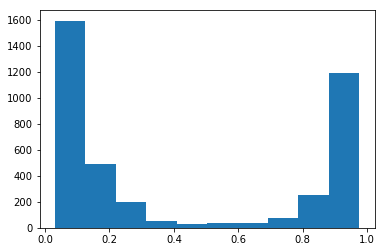

In [255]:
plt.hist(y_blend_test_pred);

In [256]:
accuracy_score(y_blend_test, blender.X_blend_test.mean(axis=1) > 0.5)

0.98689185782707334

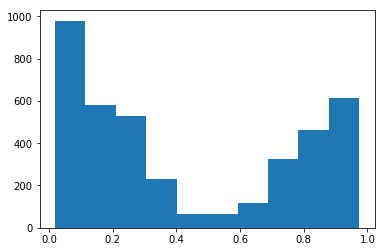

In [257]:
plt.hist(X_blend_test.mean(axis=1));

In [258]:
from scipy.stats import gmean
accuracy_score(y_blend_test, gmean(blender.X_blend_test, axis=1) > 0.5)

0.98764809679858834

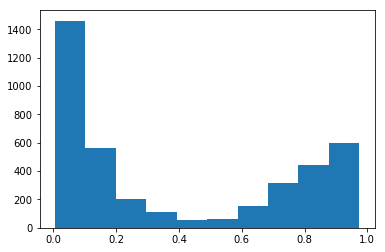

In [259]:
plt.hist(gmean(X_blend_test, axis=1));

# Hyperparameters Random Search

In [198]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold

In [199]:
# other_u_groups_sample = other_u_groups[:10]
# train_u_groups_sample, valid_u_groups_sample = train_u_groups[:5], valid_u_groups[:2]
# other_u_groups_sample, train_u_groups_sample, valid_u_groups_sample

In [200]:
# X_other, y_other, groups_other = make_subset(other_u_groups, X_sample, y_sample, groups_sample)
# X_train, y_train, groups_train = make_subset(train_u_groups_sample, X, y, groups)
# X_valid, y_valid, groups_valid = make_subset(valid_u_groups_sample, X, y, groups)

In [201]:
params_dist = {
#     'batch_size': [16, 32, 64],
    'batch_size': [32],
#     'epochs': [5, 10, 15, 20, 25, 30],
    'epochs': [30],
#     'opt': [Adam(lr=1e-4), Nadam(lr=2e-3), Adamax(lr=2e-3), Adadelta(lr=1.0)],
    'opt': [Adam(lr=1e-4)],
#     'opt_alg': [Adam, Nadam, Adamax, Adadelta],
#     'opt_lr': [1e-3, 1e-4, 2e-4, 1e-5],
#     'opt_lr': [5e-5],
#     'l1_a': [1e-1, 1e-2, 1e-3, 1e-4, 0],
#     'l2_a': [1e-1, 1e-2, 1e-3, 1e-4, 0],
    'l1_a': [0],
    'l2_a': [1e-1],
#     'init_filters': [2, 4, 8, 16],
    'init_filters': [8],
#     'dropout_p': [0, 0.25, 0.5, 0.75],
    'dropout_p': [0.5],
#     'dense_fn': [(128, 128), (128, 256), (256, 256), (256, 512), (512, 512)],
    'dense_fn': [(128, 128)],
#     'act_f': ['relu', 'elu', 'selu'],
    'act_f': ['relu'],
#     'kernel_initializer': ['he_uniform', 'he_normal', 'lecun_uniform', 'lecun_normal',
#                            'glorot_uniform', 'glorot_normal']
    'kernel_initializer': ['glorot_uniform']
}

In [202]:
def get_comb_n(params_dist):
    comb_n = 1
    for p, vals in params_dist.items():
        comb_n *= len(vals)
    return comb_n
get_comb_n(params_dist)

5

In [203]:
# def make_cv_gen(train_u_groups, valid_u_groups, groups_sample, n=2):
#     for _ in range(n):
#         train_mask = np.array([g in train_u_groups for g in groups_sample])
#         valid_mask = np.array([g in valid_u_groups for g in groups_sample])
#         yield train_mask, valid_mask
def make_cv_gen(X, y, groups, n=4):
    groupkfold = GroupKFold(n)
    return groupkfold.split(X, y, groups)

In [4]:
%%time
max_iter = 100
kclf = OffSampleKerasClassifier()
# cv_gen = make_cv_gen(train_u_groups, valid_u_groups, groups_sample, n=1)
cv_gen = make_cv_gen(X_sample, y_sample, groups_sample, n=3)
validator = RandomizedSearchCV(kclf, param_distributions=params_dist,
                               n_iter=min(get_comb_n(params_dist), max_iter),
                               n_jobs=1, cv=cv_gen, random_state=13)
validator.fit(X_sample, y_sample);

In [205]:
validator.best_params_, validator.best_score_, validator.cv_results_['rank_test_score']

({'act_f': 'relu',
  'batch_size': 32,
  'dense_fn': (128, 128),
  'dropout_p': 0.5,
  'epochs': 30,
  'init_filters': 8,
  'kernel_initializer': 'glorot_uniform',
  'l1_a': 0,
  'l2_a': 0.1,
  'opt': <keras.optimizers.Adam at 0x7f6b48318828>},
 0.91475369415237318,
 array([1, 4, 3, 2, 5], dtype=int32))

In [206]:
from copy import deepcopy, copy

In [207]:
rows = []
for f1_mean, f1_std, params in  zip(validator.cv_results_['mean_test_score'],
                                    validator.cv_results_['std_test_score'],
                                    validator.cv_results_['params']):
    row = copy(params)
    row['opt'] = params['opt'].__class__.__name__
    row.update({'f1_mean': f1_mean, 'f1_std': f1_std})
    rows.append(row)
grid_df = pd.DataFrame(rows).sort_values(by='f1_mean', ascending=False)
grid_df

,act_f,batch_size,dense_fn,dropout_p,epochs,f1_mean,f1_std,init_filters,kernel_initializer,l1_a,l2_a,opt
0,relu,32,"(128, 128)",0.5,30,0.914754,0.026403,8,glorot_uniform,0,0.1,Adam
3,relu,32,"(256, 512)",0.5,30,0.913325,0.028476,8,glorot_uniform,0,0.1,Adam
2,relu,32,"(256, 256)",0.5,30,0.904736,0.020757,8,glorot_uniform,0,0.1,Adam
1,relu,32,"(128, 256)",0.5,30,0.890959,0.014840,8,glorot_uniform,0,0.1,Adam
4,relu,32,"(512, 512)",0.5,30,0.882411,0.017956,8,glorot_uniform,0,0.1,Adam


In [208]:
# %run off_sample/utils.py
X_test, y_test, _ = make_subset(test_u_groups, X, y, groups)
evaluate_model(X_test, y_test, validator.best_estimator_)

3702/3702 [==============================] - 11s 3ms/step


,f1,prec_recall_score,prec,recall,acc
on,0.637747,0.993540,0.998808,0.468418,0.742842
off,0.800670,0.993121,0.667831,0.999477,0.742842


---

# Final Model Cross Validation

### Blended

In [14]:
print('Loading image dataset...')
X, y, groups = utils.load_img_X_y_groups(all_paths, image_shape=IMAGE_SHAPE)
print(X.shape)

print('Loading pixel dataset...')
masks = {i: utils.load_mask(p) for i, p in enumerate(all_paths)}
ions = utils.create_ion_list(all_paths)
X_p, y_p, groups_p = utils.load_pixel_xygroups(all_paths, masks, ions)
print(X_p.shape)

Loading image dataset...
(18038, 64, 64, 1)
Loading pixel dataset...


In [42]:
from collections import defaultdict
import scipy

In [43]:
u_groups = list(range(len(all_paths)))
len(u_groups)

66

In [ ]:
%%time

utils = reload(utils)
break_after_first_fold = False

folds_1level = 5
folds_2level = 5

cv_metrics = []
history_list = []

cv1 = GroupKFold(n_splits=folds_1level)
for fold_i, (other_inds, test_inds) in enumerate(cv1.split(u_groups, groups=u_groups)):
    print(f'First level fold: {fold_i}', other_inds.shape, test_inds.shape)
    other_u_groups, test_u_groups = other_inds, test_inds
    
    X_other, y_other, groups_other = utils.make_subset(other_u_groups, X, y, groups)
    X_test, y_test, groups_test = utils.make_subset(test_u_groups, X, y, groups)
    
    X_p_other, y_p_other, groups_p_other = utils.make_subset(other_u_groups, X_p, y_p, groups_p)
    X_p_test, y_p_test, groups_p_test = utils.make_subset(test_u_groups, X_p, y_p, groups_p)
    
#     data_gen = utils.OffSampleImageDataGenerator(**data_gen_args)
#     data_gen.fit(X_other)
#     X_test = data_gen.standardize(X_test)
    
    y_other_cv = []
    y_other_cv_pred = defaultdict(list)
    y_test_cv_pred = defaultdict(list)
    cv2 = GroupKFold(n_splits=folds_2level)
    for fold_j, (train_inds, valid_inds) in enumerate(cv2.split(other_u_groups, groups=other_u_groups)):
        print(f'First/Second level fold: {fold_i}/{fold_j}', train_inds.shape, valid_inds.shape)
        train_u_groups, valid_u_groups = other_u_groups[train_inds], other_u_groups[valid_inds]
        
        X_train, y_train, groups_train = utils.make_subset(train_u_groups, X, y, groups)
        X_valid, y_valid, groups_valid = utils.make_subset(valid_u_groups, X, y, groups)
        
        X_p_train, y_p_train, groups_p_train = utils.make_subset(train_u_groups, X_p, y_p, groups_p)
        X_p_valid, y_p_valid, groups_p_valid = utils.make_subset(valid_u_groups, X_p, y_p, groups_p)
        
        y_other_cv.append(y_valid)  # TODO: take into account groups
        
        # CNN
        epochs = 15
        model_cnn = utils.KerasCNN(image_shape=IMAGE_SHAPE)
        model_cnn.fit(X_train, y_train, X_valid, y_valid,
                      epochs=epochs, batch_size=32, seed=13)
        y_valid_pred = model_cnn.predict(X_valid, load_best=True)
        y_other_cv_pred['cnn'].append(y_valid_pred)
        
        # TODO?: train network on training, select best performing on validation, run on test
        history = model_cnn.fit(np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]),
                                epochs=epochs, batch_size=32, seed=13)
        history_list.append(history.history)
        y_test_pred = model_cnn.predict(X_test, load_best=False)
        y_test_cv_pred['cnn'].append(y_test_pred)
        
        # NN
        epochs = 5
        model_nn = utils.KerasNN(feature_n=X_p_train.shape[-1])
        model_nn.fit(X_p_train, y_p_train, X_p_valid, y_p_valid,
                     epochs=epochs, batch_size=512)
        y_p_valid_pred = model_nn.predict(X_p_valid, load_best=True)
        y_valid_pred = utils.pixel_corr_predict(y_p_valid_pred, groups_p_valid,
                                                X_valid, groups_valid,
                                                masks, IMAGE_SHAPE)
        y_other_cv_pred['nn'].append(y_valid_pred)
        
        model_nn.fit(scipy.sparse.vstack([X_p_train, X_p_valid]), np.concatenate([y_p_train, y_p_valid]),
                     epochs=epochs, batch_size=512)
        y_p_test_pred = model_nn.predict(X_p_test, load_best=False)
        y_test_pred = utils.pixel_corr_predict(y_p_test_pred, groups_p_test,
                                               X_test, groups_test,
                                               masks, IMAGE_SHAPE)
        y_test_cv_pred['nn'].append(y_test_pred)
        
        # LR
        print('Training LR...')
        model_lr = utils.SKLogisticRegression(n_components=50)
        model_lr.fit(X_p_train, y_p_train)
        y_p_valid_pred = model_lr.predict(X_p_valid)
        y_valid_pred = utils.pixel_corr_predict(y_p_valid_pred, groups_p_valid,
                                                X_valid, groups_valid,
                                                masks, IMAGE_SHAPE)
        y_other_cv_pred['lr'].append(y_valid_pred)
        
        model_lr.fit(scipy.sparse.vstack([X_p_train, X_p_valid]), np.concatenate([y_p_train, y_p_valid]))
        y_p_test_pred = model_lr.predict(X_p_test)
        y_test_pred = utils.pixel_corr_predict(y_p_test_pred, groups_p_test,
                                               X_test, groups_test,
                                               masks, IMAGE_SHAPE)
        y_test_cv_pred['lr'].append(y_test_pred)

    model_names = ['cnn', 'nn', 'lr']
        
    y_other_cv = np.concatenate(y_other_cv)
    for model_name in model_names:
        y_other_cv_pred[model_name] = np.concatenate(y_other_cv_pred[model_name])
        y_test_cv_pred[model_name] = np.stack(y_test_cv_pred[model_name], axis=1).mean(axis=1)
    
    # Blender
    print('Training Blender...')
    X_blend_train = np.stack([y_other_cv_pred[name] for name in model_names], axis=1)
    X_blend_test = np.stack([y_test_cv_pred[name] for name in model_names], axis=1)

    blender = sklearn.linear_model.logistic.LogisticRegressionCV(cv=5, solver='liblinear', verbose=1)
    blender.fit(X_blend_train, y_other_cv)

    y_test_pred = {}
    for name in model_names:
        y_test_pred[name] = y_test_cv_pred[name]
              
    y_test_pred['blend'] = blender.predict_proba(X_blend_test)[:,1]
    y_test_pred['mean'] = X_blend_test.mean(axis=1)
    y_test_pred['gmean'] = scipy.stats.gmean(X_blend_test, axis=1)
    
    for name, pred in y_test_pred.items():
        if len(pred) > 0:
            metrics = utils.calc_metrics(y_test, pred)
            metrics['model'] = name
            metrics['fold'] = fold_i
            cv_metrics.append(metrics)
            print(metrics, end='\n\n')

    if break_after_first_fold:
        break

metrics_df = pd.concat(cv_metrics)
metrics_df.to_msgpack('metrics_df.msgpack')
pickle.dump(history_list, open('history_list.pkl', 'wb'))

First level fold: 0 (52,) (14,)
First/Second level fold: 0/0 (41,) (11,)
Epoch 1/15
337/336 [==============================] - 35s 103ms/step - loss: 3.2207 - binary_accuracy: 0.8893 - val_loss: 1.5244 - val_binary_accuracy: 0.8985

Epoch 00001: val_binary_accuracy improved from -inf to 0.89847, saving model to custom-cnn-weights.hdf5
Epoch 2/15
337/336 [==============================] - 9s 28ms/step - loss: 0.9646 - binary_accuracy: 0.9392 - val_loss: 0.6912 - val_binary_accuracy: 0.9227

Epoch 00002: val_binary_accuracy improved from 0.89847 to 0.92267, saving model to custom-cnn-weights.hdf5
Epoch 3/15
337/336 [==============================] - 9s 28ms/step - loss: 0.5406 - binary_accuracy: 0.9473 - val_loss: 0.4497 - val_binary_accuracy: 0.9463

Epoch 00003: val_binary_accuracy improved from 0.92267 to 0.94628, saving model to custom-cnn-weights.hdf5
Epoch 4/15
337/336 [==============================] - 9s 27ms/step - loss: 0.4073 - binary_accuracy: 0.9458 - val_loss: 0.3576 - val_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.3s finished


First/Second level fold: 0/1 (41,) (11,)
Epoch 1/15
363/362 [==============================] - 39s 107ms/step - loss: 3.1544 - binary_accuracy: 0.8785 - val_loss: 1.2908 - val_binary_accuracy: 0.9817

Epoch 00001: val_binary_accuracy improved from -inf to 0.98169, saving model to custom-cnn-weights.hdf5
Epoch 2/15
363/362 [==============================] - 10s 27ms/step - loss: 0.9283 - binary_accuracy: 0.9328 - val_loss: 0.5607 - val_binary_accuracy: 0.9657

Epoch 00002: val_binary_accuracy did not improve from 0.98169
Epoch 3/15
363/362 [==============================] - 10s 27ms/step - loss: 0.5176 - binary_accuracy: 0.9378 - val_loss: 0.3400 - val_binary_accuracy: 0.9836

Epoch 00003: val_binary_accuracy improved from 0.98169 to 0.98364, saving model to custom-cnn-weights.hdf5
Epoch 4/15
363/362 [==============================] - 10s 27ms/step - loss: 0.3925 - binary_accuracy: 0.9423 - val_loss: 0.3109 - val_binary_accuracy: 0.9677

Epoch 00004: val_binary_accuracy did not improve 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.2s finished


First/Second level fold: 0/2 (42,) (10,)
Epoch 1/15
371/370 [==============================] - 50s 134ms/step - loss: 3.1249 - binary_accuracy: 0.8824 - val_loss: 1.3731 - val_binary_accuracy: 0.9315

Epoch 00001: val_binary_accuracy improved from -inf to 0.93152, saving model to custom-cnn-weights.hdf5
Epoch 2/15
371/370 [==============================] - 17s 45ms/step - loss: 0.9329 - binary_accuracy: 0.9363 - val_loss: 0.6531 - val_binary_accuracy: 0.9440

Epoch 00002: val_binary_accuracy improved from 0.93152 to 0.94401, saving model to custom-cnn-weights.hdf5
Epoch 3/15
371/370 [==============================] - 17s 45ms/step - loss: 0.5454 - binary_accuracy: 0.9422 - val_loss: 0.4579 - val_binary_accuracy: 0.9384

Epoch 00003: val_binary_accuracy did not improve from 0.94401
Epoch 4/15
371/370 [==============================] - 17s 45ms/step - loss: 0.4028 - binary_accuracy: 0.9465 - val_loss: 0.3415 - val_binary_accuracy: 0.9630

Epoch 00004: val_binary_accuracy improved from 0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.3s finished


First/Second level fold: 0/3 (42,) (10,)
Epoch 1/15
356/355 [==============================] - 46s 130ms/step - loss: 3.0894 - binary_accuracy: 0.8880 - val_loss: 1.3421 - val_binary_accuracy: 0.9446

Epoch 00001: val_binary_accuracy improved from -inf to 0.94462, saving model to custom-cnn-weights.hdf5
Epoch 2/15
356/355 [==============================] - 9s 26ms/step - loss: 0.9214 - binary_accuracy: 0.9327 - val_loss: 0.6901 - val_binary_accuracy: 0.9263

Epoch 00002: val_binary_accuracy did not improve from 0.94462
Epoch 3/15
356/355 [==============================] - 9s 26ms/step - loss: 0.5245 - binary_accuracy: 0.9391 - val_loss: 0.4591 - val_binary_accuracy: 0.9389

Epoch 00003: val_binary_accuracy did not improve from 0.94462
Epoch 4/15
356/355 [==============================] - 9s 26ms/step - loss: 0.3930 - binary_accuracy: 0.9443 - val_loss: 0.4178 - val_binary_accuracy: 0.9399

Epoch 00004: val_binary_accuracy did not improve from 0.94462
Epoch 5/15
356/355 [===============

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.6s finished


First/Second level fold: 0/4 (42,) (10,)
Epoch 1/15
346/345 [==============================] - 51s 148ms/step - loss: 3.1480 - binary_accuracy: 0.8926 - val_loss: 1.4085 - val_binary_accuracy: 0.9153

Epoch 00001: val_binary_accuracy improved from -inf to 0.91533, saving model to custom-cnn-weights.hdf5
Epoch 2/15
346/345 [==============================] - 11s 31ms/step - loss: 0.9115 - binary_accuracy: 0.9389 - val_loss: 0.5792 - val_binary_accuracy: 0.9652

Epoch 00002: val_binary_accuracy improved from 0.91533 to 0.96523, saving model to custom-cnn-weights.hdf5
Epoch 3/15
346/345 [==============================] - 11s 31ms/step - loss: 0.5230 - binary_accuracy: 0.9388 - val_loss: 0.4410 - val_binary_accuracy: 0.9356

Epoch 00003: val_binary_accuracy did not improve from 0.96523
Epoch 4/15
346/345 [==============================] - 11s 31ms/step - loss: 0.3880 - binary_accuracy: 0.9487 - val_loss: 0.3257 - val_binary_accuracy: 0.9601

Epoch 00004: val_binary_accuracy did not improve 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.2s finished


Training Blender...
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]           f1      prec    recall       acc model  fold
on   0.977313  0.985202  0.969550  0.973671   cnn     0
off  0.968635  0.958029  0.979478  0.973671   cnn     0

           f1      prec    recall       acc model  fold
on   0.966615  0.968542  0.964695  0.961022    nn     0
off  0.953178  0.950526  0.955846  0.961022    nn     0

           f1      prec    recall       acc model  fold
on   0.944420  0.936632  0.952339  0.934435    lr     0
off  0.920076  0.931210  0.909204  0.934435    lr     0

           f1     prec    recall       acc  model  fold
on   0.9

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


           f1      prec    recall       acc model  fold
on   0.987638  0.988074  0.987202  0.985545  mean     0
off  0.982598  0.981988  0.983209  0.985545  mean     0

           f1      prec    recall       acc  model  fold
on   0.987219  0.985915  0.988526  0.985028  gmean     0
off  0.981931  0.983770  0.980100  0.985028  gmean     0

First level fold: 1 (53,) (13,)
First/Second level fold: 1/0 (42,) (11,)
Epoch 1/15
368/367 [==============================] - 54s 146ms/step - loss: 3.1143 - binary_accuracy: 0.8952 - val_loss: 1.5244 - val_binary_accuracy: 0.8520

Epoch 00001: val_binary_accuracy improved from -inf to 0.85199, saving model to custom-cnn-weights.hdf5
Epoch 2/15
368/367 [==============================] - 11s 29ms/step - loss: 0.9053 - binary_accuracy: 0.9423 - val_loss: 0.7969 - val_binary_accuracy: 0.8633

Epoch 00002: val_binary_accuracy improved from 0.85199 to 0.86328, saving model to custom-cnn-weights.hdf5
Epoch 3/15
368/367 [==============================] - 11

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.4s finished


First/Second level fold: 1/1 (42,) (11,)
Epoch 1/15
389/388 [==============================] - 59s 150ms/step - loss: 3.0170 - binary_accuracy: 0.8757 - val_loss: 1.2558 - val_binary_accuracy: 0.9516

Epoch 00001: val_binary_accuracy improved from -inf to 0.95161, saving model to custom-cnn-weights.hdf5
Epoch 2/15
389/388 [==============================] - 11s 27ms/step - loss: 0.8712 - binary_accuracy: 0.9313 - val_loss: 0.5275 - val_binary_accuracy: 0.9786

Epoch 00002: val_binary_accuracy improved from 0.95161 to 0.97858, saving model to custom-cnn-weights.hdf5
Epoch 3/15
389/388 [==============================] - 11s 28ms/step - loss: 0.5236 - binary_accuracy: 0.9345 - val_loss: 0.3704 - val_binary_accuracy: 0.9841

Epoch 00003: val_binary_accuracy improved from 0.97858 to 0.98413, saving model to custom-cnn-weights.hdf5
Epoch 4/15
389/388 [==============================] - 11s 28ms/step - loss: 0.4063 - binary_accuracy: 0.9403 - val_loss: 0.3016 - val_binary_accuracy: 0.9754

Epoc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.3s finished


First/Second level fold: 1/2 (42,) (11,)
Epoch 1/15
376/375 [==============================] - 64s 171ms/step - loss: 3.1091 - binary_accuracy: 0.8842 - val_loss: 1.3931 - val_binary_accuracy: 0.9110

Epoch 00001: val_binary_accuracy improved from -inf to 0.91098, saving model to custom-cnn-weights.hdf5
Epoch 2/15
376/375 [==============================] - 12s 31ms/step - loss: 0.9127 - binary_accuracy: 0.9354 - val_loss: 0.6553 - val_binary_accuracy: 0.9260

Epoch 00002: val_binary_accuracy improved from 0.91098 to 0.92599, saving model to custom-cnn-weights.hdf5
Epoch 3/15
376/375 [==============================] - 12s 31ms/step - loss: 0.5134 - binary_accuracy: 0.9441 - val_loss: 0.4363 - val_binary_accuracy: 0.9359

Epoch 00003: val_binary_accuracy improved from 0.92599 to 0.93588, saving model to custom-cnn-weights.hdf5
Epoch 4/15
376/375 [==============================] - 12s 32ms/step - loss: 0.3827 - binary_accuracy: 0.9505 - val_loss: 0.4263 - val_binary_accuracy: 0.9308

Epoc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.8s finished


First/Second level fold: 1/3 (43,) (10,)
Epoch 1/15
363/362 [==============================] - 95s 261ms/step - loss: 3.1799 - binary_accuracy: 0.8586 - val_loss: 1.9298 - val_binary_accuracy: 0.5629

Epoch 00001: val_binary_accuracy improved from -inf to 0.56287, saving model to custom-cnn-weights.hdf5
Epoch 2/15
363/362 [==============================] - 36s 99ms/step - loss: 0.9806 - binary_accuracy: 0.9191 - val_loss: 1.1857 - val_binary_accuracy: 0.5629

Epoch 00002: val_binary_accuracy did not improve from 0.56287
Epoch 3/15
363/362 [==============================] - 36s 99ms/step - loss: 0.5629 - binary_accuracy: 0.9310 - val_loss: 0.9996 - val_binary_accuracy: 0.5629

Epoch 00003: val_binary_accuracy did not improve from 0.56287
Epoch 4/15
363/362 [==============================] - 36s 99ms/step - loss: 0.4333 - binary_accuracy: 0.9371 - val_loss: 0.9129 - val_binary_accuracy: 0.5629

Epoch 00004: val_binary_accuracy did not improve from 0.56287
Epoch 5/15
363/362 [============

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s finished


First/Second level fold: 1/4 (43,) (10,)
Epoch 1/15
376/375 [==============================] - 71s 189ms/step - loss: 3.0210 - binary_accuracy: 0.8865 - val_loss: 1.3056 - val_binary_accuracy: 0.9266

Epoch 00001: val_binary_accuracy improved from -inf to 0.92661, saving model to custom-cnn-weights.hdf5
Epoch 2/15
376/375 [==============================] - 12s 31ms/step - loss: 0.8665 - binary_accuracy: 0.9366 - val_loss: 0.5600 - val_binary_accuracy: 0.9606

Epoch 00002: val_binary_accuracy improved from 0.92661 to 0.96058, saving model to custom-cnn-weights.hdf5
Epoch 3/15
376/375 [==============================] - 12s 31ms/step - loss: 0.4981 - binary_accuracy: 0.9459 - val_loss: 0.4912 - val_binary_accuracy: 0.9242

Epoch 00003: val_binary_accuracy did not improve from 0.96058
Epoch 4/15
376/375 [==============================] - 12s 32ms/step - loss: 0.3828 - binary_accuracy: 0.9479 - val_loss: 0.3435 - val_binary_accuracy: 0.9507

Epoch 00004: val_binary_accuracy did not improve 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.3s finished


Training Blender...
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


           f1      prec    recall       acc model  fold
on   0.964464  0.938286  0.992145  0.960727   cnn     1
off  0.956112  0.990233  0.924264  0.960727   cnn     1

           f1      prec    recall      acc model  fold
on   0.978672  0.987093  0.970393  0.97728    nn     1
off  0.975694  0.966300  0.985273  0.97728    nn     1

           f1      prec    recall      acc model  fold
on   0.962236  0.947307  0.977644  0.95878    lr     1
off  0.954627  0.973052  0.936886  0.95878    lr     1

           f1      prec    recall       acc  model  fold
on   0.970145  0.949653  0.991541  0.967218  blend     1
off  0.963656  0.989653  0.938990  0.967218  blend     1

           f1      prec    recall       acc model  fold
on   0.971259  0.952907  0.990332  0.968517  mean     1
off  0.965196  0.988244  0.943198  0.968517  mean     1

           f1      prec    recall       acc  model  fold
on   0.969858  0.949104  0.991541  0.966894  gmean     1
off  0.963283  0.989645  0.938289  0.966894 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.7s finished


First/Second level fold: 2/1 (42,) (11,)
Epoch 1/15
370/369 [==============================] - 87s 234ms/step - loss: 3.0381 - binary_accuracy: 0.8896 - val_loss: 1.3348 - val_binary_accuracy: 0.9092

Epoch 00001: val_binary_accuracy improved from -inf to 0.90923, saving model to custom-cnn-weights.hdf5
Epoch 2/15
370/369 [==============================] - 19s 51ms/step - loss: 0.8617 - binary_accuracy: 0.9397 - val_loss: 0.5796 - val_binary_accuracy: 0.9501

Epoch 00002: val_binary_accuracy improved from 0.90923 to 0.95008, saving model to custom-cnn-weights.hdf5
Epoch 3/15
370/369 [==============================] - 19s 51ms/step - loss: 0.4885 - binary_accuracy: 0.9482 - val_loss: 0.4913 - val_binary_accuracy: 0.9113

Epoch 00003: val_binary_accuracy did not improve from 0.95008
Epoch 4/15
370/369 [==============================] - 19s 51ms/step - loss: 0.3807 - binary_accuracy: 0.9451 - val_loss: 0.4314 - val_binary_accuracy: 0.9080

Epoch 00004: val_binary_accuracy did not improve 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.9s finished


First/Second level fold: 2/2 (42,) (11,)
Epoch 1/15
361/360 [==============================] - 88s 244ms/step - loss: 3.1511 - binary_accuracy: 0.8827 - val_loss: 1.3661 - val_binary_accuracy: 0.9432

Epoch 00001: val_binary_accuracy improved from -inf to 0.94322, saving model to custom-cnn-weights.hdf5
Epoch 2/15
361/360 [==============================] - 13s 37ms/step - loss: 0.9316 - binary_accuracy: 0.9359 - val_loss: 0.6565 - val_binary_accuracy: 0.9387

Epoch 00002: val_binary_accuracy did not improve from 0.94322
Epoch 3/15
361/360 [==============================] - 13s 36ms/step - loss: 0.5414 - binary_accuracy: 0.9394 - val_loss: 0.4145 - val_binary_accuracy: 0.9653

Epoch 00003: val_binary_accuracy improved from 0.94322 to 0.96531, saving model to custom-cnn-weights.hdf5
Epoch 4/15
361/360 [==============================] - 13s 36ms/step - loss: 0.4153 - binary_accuracy: 0.9467 - val_loss: 0.3598 - val_binary_accuracy: 0.9544

Epoch 00004: val_binary_accuracy did not improve 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.7s finished


First/Second level fold: 2/3 (43,) (10,)
Epoch 1/15
400/399 [==============================] - 95s 239ms/step - loss: 2.9674 - binary_accuracy: 0.8671 - val_loss: 1.2024 - val_binary_accuracy: 0.9575

Epoch 00001: val_binary_accuracy improved from -inf to 0.95751, saving model to custom-cnn-weights.hdf5
Epoch 2/15
400/399 [==============================] - 13s 32ms/step - loss: 0.8443 - binary_accuracy: 0.9356 - val_loss: 0.5419 - val_binary_accuracy: 0.9691

Epoch 00002: val_binary_accuracy improved from 0.95751 to 0.96910, saving model to custom-cnn-weights.hdf5
Epoch 3/15
400/399 [==============================] - 13s 32ms/step - loss: 0.4976 - binary_accuracy: 0.9396 - val_loss: 0.3632 - val_binary_accuracy: 0.9661

Epoch 00003: val_binary_accuracy did not improve from 0.96910
Epoch 4/15
400/399 [==============================] - 13s 32ms/step - loss: 0.3913 - binary_accuracy: 0.9431 - val_loss: 0.2750 - val_binary_accuracy: 0.9798

Epoch 00004: val_binary_accuracy improved from 0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.0s finished


First/Second level fold: 2/4 (43,) (10,)
Epoch 1/15
392/391 [==============================] - 105s 267ms/step - loss: 2.9683 - binary_accuracy: 0.8856 - val_loss: 1.4046 - val_binary_accuracy: 0.8505

Epoch 00001: val_binary_accuracy improved from -inf to 0.85050, saving model to custom-cnn-weights.hdf5
Epoch 2/15
392/391 [==============================] - 20s 51ms/step - loss: 0.8406 - binary_accuracy: 0.9409 - val_loss: 0.6287 - val_binary_accuracy: 0.9128

Epoch 00002: val_binary_accuracy improved from 0.85050 to 0.91276, saving model to custom-cnn-weights.hdf5
Epoch 3/15
392/391 [==============================] - 20s 51ms/step - loss: 0.4925 - binary_accuracy: 0.9436 - val_loss: 0.4516 - val_binary_accuracy: 0.9274

Epoch 00003: val_binary_accuracy improved from 0.91276 to 0.92736, saving model to custom-cnn-weights.hdf5
Epoch 4/15
392/391 [==============================] - 20s 52ms/step - loss: 0.3694 - binary_accuracy: 0.9511 - val_loss: 0.3640 - val_binary_accuracy: 0.9243

Epo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.5s finished


Training Blender...
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


           f1      prec    recall      acc model  fold
on   0.946065  0.991353  0.904735  0.93735   cnn     2
off  0.925276  0.870200  0.987794  0.93735   cnn     2

           f1      prec    recall       acc model  fold
on   0.950838  0.942414  0.959414  0.939747    nn     2
off  0.922193  0.935426  0.909329  0.939747    nn     2

           f1      prec    recall       acc model  fold
on   0.940028  0.930425  0.949831  0.926395    lr     2
off  0.904741  0.919820  0.890148  0.926395    lr     2

           f1      prec   recall       acc  model  fold
on   0.973247  0.972425  0.97407  0.967477  blend     2
off  0.958533  0.959790  0.95728  0.967477  blend     2

           f1      prec    recall       acc model  fold
on   0.975679  0.979001  0.972379  0.970558  mean     2
off  0.962706  0.957722  0.967742  0.970558  mean     2

           f1      prec    recall       acc  model  fold
on   0.972745  0.969748  0.975761  0.966792  gmean     2
off  0.957512  0.962148  0.952921  0.966792 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.0s finished


First/Second level fold: 3/1 (42,) (11,)
Epoch 1/15
331/330 [==============================] - 107s 324ms/step - loss: 3.3528 - binary_accuracy: 0.8580 - val_loss: 1.5082 - val_binary_accuracy: 0.9613

Epoch 00001: val_binary_accuracy improved from -inf to 0.96134, saving model to custom-cnn-weights.hdf5
Epoch 2/15
331/330 [==============================] - 13s 39ms/step - loss: 1.0766 - binary_accuracy: 0.9231 - val_loss: 0.6283 - val_binary_accuracy: 0.9797

Epoch 00002: val_binary_accuracy improved from 0.96134 to 0.97969, saving model to custom-cnn-weights.hdf5
Epoch 3/15
331/330 [==============================] - 13s 38ms/step - loss: 0.6166 - binary_accuracy: 0.9274 - val_loss: 0.4173 - val_binary_accuracy: 0.9682

Epoch 00003: val_binary_accuracy did not improve from 0.97969
Epoch 4/15
331/330 [==============================] - 13s 39ms/step - loss: 0.4614 - binary_accuracy: 0.9300 - val_loss: 0.3575 - val_binary_accuracy: 0.9646

Epoch 00004: val_binary_accuracy did not improve

In [45]:
# metrics_df = pd.concat(cv_metrics, sort=False)

In [68]:
agg_metrics_df = metrics_df.reset_index().groupby(['model', 'index']).agg([np.mean, np.std]).sort_index()
agg_metrics_df

f1                prec              recall            \
                 mean       std      mean       std      mean       std   
model index                                                               
blend off    0.976219  0.014539  0.980084  0.013659  0.972665  0.023860   
      on     0.982465  0.010415  0.979581  0.019055  0.985558  0.009040   
cnn   off    0.962340  0.023611  0.955065  0.050104  0.971678  0.026717   
      on     0.971516  0.017064  0.977893  0.022263  0.966303  0.036576   
gmean off    0.975847  0.014783  0.980936  0.012553  0.971073  0.024317   
      on     0.982258  0.010497  0.978503  0.019161  0.986225  0.008176   
lr    off    0.942047  0.030396  0.941498  0.029186  0.943556  0.046217   
      on     0.958326  0.017915  0.959939  0.030497  0.957298  0.020294   
mean  off    0.977708  0.013283  0.979201  0.013803  0.976473  0.021512   
      on     0.983431  0.009789  0.982168  0.017700  0.984868  0.008969   
nn    off    0.950174  0.023628  0.943674  0.018506  0.957047  0.033295   
      on     0.963668  0.013985  0.969708  0.020759  0.957860  0.012472   

                  acc           fold            
                 mean       std mean       std  
model index                                     
blend off    0.979870  0.011997    2  1.581139  
      on     0.979870  0.011997    2  1.581139  
cnn   off    0.967592  0.019784    2  1.581139  
      on     0.967592  0.019784    2  1.581139  
gmean off    0.979602  0.012130    2  1.581139  
      on     0.979602  0.012130    2  1.581139  
lr    off    0.951658  0.022611    2  1.581139  
      on     0.951658  0.022611    2  1.581139  
mean  off    0.981041  0.011146    2  1.581139  
      on     0.981041  0.011146    2  1.581139  
nn    off    0.958105  0.017657    2  1.581139  
      on     0.958105  0.017657    2  1.581139

In [73]:
agg_metrics_df.loc[('mean',)]

f1                prec              recall                 acc  \
           mean       std      mean       std      mean       std      mean   
index                                                                         
off    0.977708  0.013283  0.979201  0.013803  0.976473  0.021512  0.981041   
on     0.983431  0.009789  0.982168  0.017700  0.984868  0.008969  0.981041   

                fold            
            std mean       std  
index                           
off    0.011146    2  1.581139  
on     0.011146    2  1.581139

In [585]:
# utils.plot_learning_graph(history_list, attempts=2)

In [114]:
df = metrics_df[metrics_df.attempt == 'avg']
df[['f1', 'prec', 'recall', 'acc']].groupby(df.index).agg([np.mean, np.std])

f1                prec              recall                 acc  \
         mean       std      mean       std      mean       std      mean   
off  0.958427  0.006822  0.930398  0.011093  0.988280  0.007538  0.962964   
on   0.966356  0.010148  0.991119  0.005449  0.942971  0.019093  0.963186   

               
          std  
off  0.008548  
on   0.008556

In [117]:
df[df.fold == 0]

,f1,prec,recall,acc,fold,attempt
on,0.979592,0.996226,0.963504,0.975711,0,avg
off,0.970007,0.946773,0.994410,0.975711,0,avg


In [98]:
df = metrics_df[metrics_df.attempt == 'avg']
df[['f1', 'prec', 'recall', 'acc']].groupby(df.index).agg([np.mean, np.std])

f1                prec              recall                 acc  \
         mean       std      mean       std      mean       std      mean   
off  0.968362  0.023722  0.947379  0.039702  0.990839  0.007010  0.973019   
on   0.976612  0.016249  0.992963  0.005821  0.960998  0.026827  0.973352   

               
          std  
off  0.019323  
on   0.018954

In [122]:
def baseline_predict(X, y):
    y_pred = []
    for img in X:
        corr = np.corrcoef(img[:,:,0].flatten(), img[:,:,1].flatten())[0,1]
        y_pred.append(corr > 0)
    return np.array(y_pred).astype(int)

In [121]:
sklearn.metrics.accuracy_score(y[:,1], y_pred)

0.97704845326532874

In [123]:
folds = 5
baseline_cv_metrics = []
cv1 = GroupKFold(n_splits=folds)
for fold_i, (train_inds, test_inds) in enumerate(cv1.split(X, y, groups)):
    X_train, y_train = X[train_inds], y[train_inds]
    X_test, y_test = X[test_inds], y[test_inds]
    
    y_pred = baseline_predict(X_test, y_test)
    acc = sklearn.metrics.accuracy_score(y_test[:,1], y_pred)
    baseline_cv_metrics.append({
        'fold': fold_i,
        'acc': acc
    })
base_metrics = pd.DataFrame(baseline_cv_metrics)

In [126]:
base_metrics

,acc,fold
0,0.979851,0
1,0.975725,1
2,0.962521,2
3,0.985703,3
4,0.981347,4


In [128]:
base_metrics.acc.agg([np.mean, np.std])

mean    0.977029
std     0.008860
Name: acc, dtype: float64

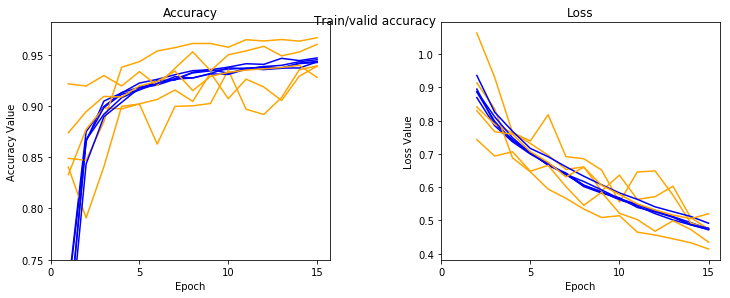

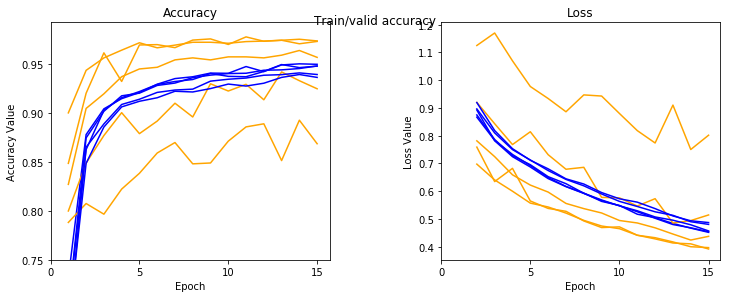

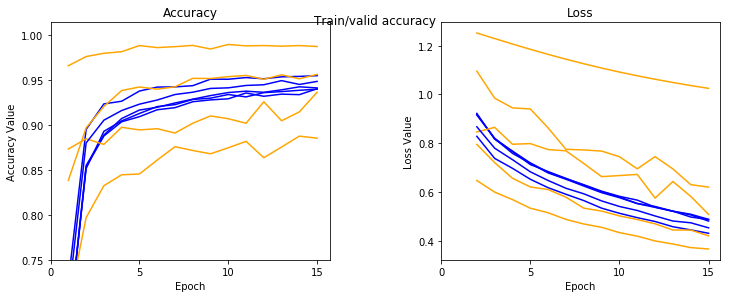

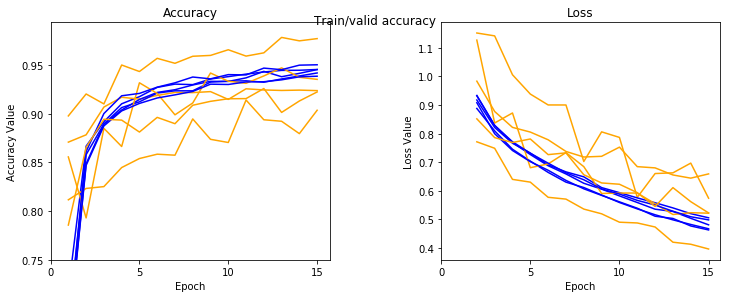

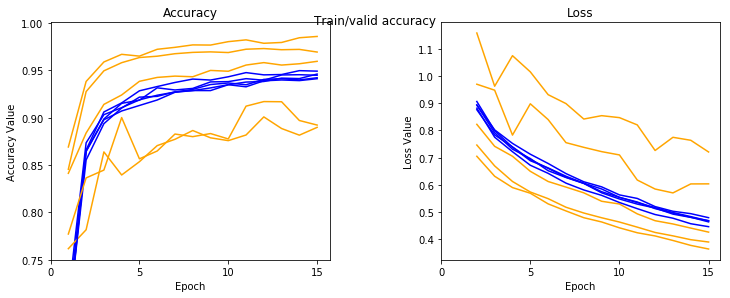

In [115]:
#%run off_sample/utils.py
for fold in range(folds):
    utils.plot_learning_graph(history_list[fold*attempts:(fold+1)*attempts], attempts)
    plt.show()

### Shallow NN

In [46]:
all_ds_names = [p.name for p in all_paths]
gs_path, len(all_paths)

(PosixPath('GS/raw_images'), 66)

In [49]:
masks = {p.name: utils.load_mask(p) for p in all_paths}
ions = utils.create_ion_list(all_paths)
len(masks), len(ions)

(66, 9273)

In [50]:
X, y, groups = utils.prepare_pixel_xygroups(all_paths, masks, ions)
X = X.tocsr()
X.shape

(1285244, 9273)

In [84]:
folds = 5
pred_masks = {}

metrics_list = []

cv = sklearn.model_selection.GroupKFold(n_splits=folds)
for fold_i, (rest_inds, test_inds) in enumerate(cv.split(X, y, groups)):
    X_rest, y_rest, groups_rest = X[rest_inds], y[rest_inds], groups[rest_inds]
    X_test, y_test, groups_test = X[test_inds], y[test_inds], groups[test_inds]
    
    cv2 = sklearn.model_selection.GroupKFold(n_splits=5)
    train_inds, valid_inds = next(cv2.split(X_rest, y_rest, groups_rest))
    X_train, y_train = X_rest[train_inds], y_rest[train_inds]
    X_valid, y_valid = X_rest[valid_inds], y_rest[valid_inds]
    
    # create, fit, predict

    acc = sklearn.metrics.accuracy_score(y_img, y_img_pred)
    acc_true = sklearn.metrics.accuracy_score(y_img, y_img_pred_true)
    m = {
        'fold': fold_i,
        'acc': acc,
        'acc_true_mask': acc_true,
    }
    metrics_list.append(m)
    
    break
metrics = pd.DataFrame(metrics_list)

Train on 822541 samples, validate on 205348 samples
Epoch 1/10
822541/822541 [==============================] - 47s 58us/step - loss: 1.0878 - binary_accuracy: 0.8067 - val_loss: 0.7009 - val_binary_accuracy: 0.8621
Epoch 2/10
822541/822541 [==============================] - 45s 55us/step - loss: 0.3697 - binary_accuracy: 0.9177 - val_loss: 0.4548 - val_binary_accuracy: 0.8402
Epoch 3/10
822541/822541 [==============================] - 45s 55us/step - loss: 0.2148 - binary_accuracy: 0.9354 - val_loss: 0.4109 - val_binary_accuracy: 0.8082
Epoch 4/10
822541/822541 [==============================] - 47s 57us/step - loss: 0.1938 - binary_accuracy: 0.9384 - val_loss: 0.4193 - val_binary_accuracy: 0.8074
Epoch 5/10
822541/822541 [==============================] - 46s 56us/step - loss: 0.1910 - binary_accuracy: 0.9386 - val_loss: 0.3995 - val_binary_accuracy: 0.8297
Epoch 6/10
822541/822541 [==============================] - 46s 56us/step - loss: 0.1899 - binary_accuracy: 0.9393 - val_loss: 0

In [85]:
metrics

,acc,acc_true_mask,fold
0,0.965045,0.974366,0


In [86]:
metrics

,acc,acc_true_mask,fold
0,0.965045,0.974366,0


In [63]:
np.mean([0.956889018351, 0.949550977285, 0.974595109559, 0.991404781091, 0.939194324804])

0.96232684221800002

---